In [1]:
import os, json, urllib, requests, webbrowser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import linregress

# Variables que influyen en la irradiación solar

Retomando el proyecto de la aplicación de geoingenieria para la selección de ciudades estadounidenses con el mayor beneficio por bloqueo solar para reducir el consumo de aire acondicionado, asi como para hacer la temperatura de las ciudades más templadas, en el proyecto pasado se demostró que las ciudades más sureñas son las más viables y en especifico las del suroeste estadounidense debido a la baja presencia de nubes, bajas velocidades de viento, baja humedad y altas temperaturas. 

# Siguiente paso

La idea para este proyecto es determinar cuales variables dadas por el API de la Nasa Power Larc son las que mejor correlacionan con el parámetro principal, que es "All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day".

Sabiendo cuales son los parámetros quemejor se correlacionan, primero podremos jerarquizar de manera descendente la imoprtancia de los parámetros para saber a cuales les damos más peso para continuar con nuestro proyecto más adelante. 

De la misma manera se hara un Principal Component Analysis para reducir la complejidad de nuestra matriz de variables por ciudad y asi facilitar análisis posteriores. 

Finalmente se hará un estudio Augmente Dicky Fuller test para comprobar la estacionalidad de nuestra información

In [3]:
popdf=pd.read_excel('Cities_population.xlsx')
popdf=popdf.sort_values(['POPULATION'], ascending=False).reset_index(drop=True)
popdf

,CITY,POPULATION
0,New York,8336817
1,Los Angeles,3979576
2,Houston,2320268
3,Chicago,2263976
4,Phoenix,1680992
5,Philadelphia,1584064
6,San Antonio,1547253
7,San Diego,1423851
8,Dallas,1343573
9,San Jose,1021795


In [4]:
# Lista de top 10 ciudades de nueva york por población
    
city_dict={'new_york':(40.7152,-73.9958), 'los_angeles':(34.0118, -118.1361), \
           'phoenix':(33.4958,-112.0140), 'dallas':(32.7782, -96.8391), \
           'san_jose':(37.3348, -121.9208), 'san_antonio':(29.4278, -98.4569),\
           'seatle':(47.6100, -122.3094), 'philadelphia':(39.9520, -75.1647), \
           'san_diego':(32.7182, -117.1563), 'houston':(29.7455,-95.3230),\
          'jacksonville':(30.347,-81.3862), 'chicago':(41.93,-87.68)}

#locations es la lista con las coordenadas por ciudad
locations=[city_dict[element] for element in city_dict]

#base_url es la url genérica para la obtención de APIS.
base_url =r'https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?&request=execute&identifier=SinglePoint&parameters=FRQ_NROVRCST_70_18_GMT,FRQ_BRKNCLD_10_70_18_GMT,FRQ_CLRSKY_0_10_18_GMT,CLD_AMT,PRECTOT,TQV,QV2M,PS,T2M,WS50M,EQVLNT_NO_SUN_BLACKDAYS_MONTH,ALLSKY_SFC_SW_DWN,KT,DNR,MIDDAY_INSOL,SG_DAY_HOUR_AVG,SRF_ALB,ALLSKY_TOA_SW_DWN&userCommunity=SSE&tempAverage=CLIMATOLOGY&outputList=JSON&lat={latitude}&lon={longitude}'
    
#Se crean dos dataframes para el manejo de la información
#step_df es por cada ciudad, main_df es el dataframe compilador
#city_df es para agregar el nombre de la ciudad como dato
main_df=pd.DataFrame()
step_df=pd.DataFrame()
city_df=pd.DataFrame()

#Función city que convierte coordenadas en la llave ciudad. 
#donde 'y' son las coordenadas 
#utiliza la lista "city_dict" y el método items()

def city(y): 
    for key, value in city_dict.items(): 
         if y == value: 
             return key 
  
    return "key doesn't exist"


#Inicializa loop para crear Dataframe
for latitude, longitude in locations:
    api_request_url = base_url.format(longitude=longitude, latitude=latitude) #formato modificable para ingresar coordenadas de respectiva ciudad
    
# Python Memory Object
    json_response = json.loads(requests.get(api_request_url).content.decode('utf-8'))
    
#Converting into transition DataFrame
    city_df['CITY']=[city((latitude, longitude))for i in range(13)] #makes a series with the name of the city for given lat and long
    step_df=pd.DataFrame(json_response['features'][0]['properties']['parameter'])
    step_df.insert(0,"CITY",[city((latitude, longitude))for i in range(13)]) #inserta al inicio lista con el nombre de la ciudad correspondiente, utiliza la funcón 'city'
    
    
#Appending to main DataFrame
    main_df=main_df.append(step_df)
    
main_df
    
    

,CITY,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CLD_AMT,DNR,EQVLNT_NO_SUN_BLACKDAYS_MONTH,FRQ_BRKNCLD_10_70_18_GMT,FRQ_CLRSKY_0_10_18_GMT,FRQ_NROVRCST_70_18_GMT,KT,MIDDAY_INSOL,PRECTOT,PS,QV2M,SG_DAY_HOUR_AVG,SRF_ALB,T2M,TQV,WS50M
1,new_york,1.97,4.19,66.6,3.43,4.72,25.07,9.97,64.96,0.48,299.00,2.79,101.27,3.25,9.62,0.10,-0.64,0.95,7.05
10,new_york,3.26,6.31,51.9,4.54,4.18,14.52,31.09,54.40,0.51,405.09,3.23,101.27,7.45,11.17,0.06,13.21,1.87,6.04
11,new_york,2.14,4.57,61.4,3.47,5.88,19.09,20.00,60.91,0.47,289.35,3.10,101.36,5.43,9.97,0.06,7.49,1.44,6.67
12,new_york,1.73,3.75,62.8,3.18,6.98,23.90,16.57,59.53,0.46,260.42,3.16,101.30,3.89,9.33,0.07,2.25,1.09,6.95
13,new_york,3.98,7.85,60.9,4.55,-999.00,-999.00,-999.00,-999.00,0.51,-999.00,3.25,101.16,7.48,-999.00,0.07,11.19,1.98,6.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,chicago,5.29,11.02,66.0,4.68,5.39,7.77,19.79,72.43,0.49,569.06,3.40,99.08,7.96,14.55,0.12,13.80,2.15,6.92
6,chicago,5.91,11.61,60.9,5.38,2.53,13.33,20.91,65.76,0.51,626.93,3.31,99.06,11.00,15.18,0.12,19.38,2.85,5.95
7,chicago,5.99,11.27,52.7,5.76,6.88,23.75,21.41,54.84,0.54,636.57,3.18,99.16,12.93,14.88,0.13,22.65,3.24,5.44
8,chicago,5.15,10.06,51.4,5.08,3.43,22.43,20.82,56.74,0.52,578.70,3.40,99.26,12.35,13.85,0.12,22.11,3.07,5.31


In [5]:
#Comienza DF Manipulation


#Crea una lista con los nombres cortos de los parámetros (llaves diccionario)
shortname_list=list(json_response['parameterInformation'].keys())

#Crea lista auxiliar 
head_list=['longname', 'units']

#Crea lista con nombre largo + unidad de parámetro (valores de diccionario)
head_list=['longname', 'units']
values_list=[json_response['parameterInformation'][i][j] for i in shortname_list for j in head_list] #crea una lista con los nombres largos + unidades de manera intercalada
joined_v_list=[ ' '.join(x) for x in zip(values_list[0::2], values_list[1::2])] #concatena nombre largo +

#Crea diccionario de encabezados
head_dict = dict(zip(shortname_list, joined_v_list))
head_dict['index']='MONTH'

#Ordena tabla, Resetea el Index y Renombra Columnas
#main_df.sort_values(['CITY', 'MONTH'], ascending=[True, True], inplace=True)
main_df.reset_index(inplace=True)
main_df=main_df.rename(columns=head_dict) #cambia los nombres del encabezado de acuerdo al diccionario
main_df.MONTH=main_df['MONTH'].astype('int32')

main_df

,MONTH,CITY,All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day,Top-of-atmosphere Insolation kW-hr/m^2/day,Daylight Cloud Amount %,Direct Normal Radiation kW-hr/m^2/day,Equivalent Number Of NO-SUN Or BLACK Days Over A Consecutive Month Period days,Frequency Of Broken-cloud Skies 10 - 70 % At 18 GMT %,Frequency Of Clear Skies < 10% At 18 GMT %,Frequency Of Near-overcast Skies >= 70% At 18 GMT %,Insolation Clearness Index dimensionless,Midday Insolation Incident On A Horizontal Surface W m-2,Precipitation mm day-1,Surface Pressure kPa,Specific Humidity at 2 Meters g/kg,Daylight Hours hours,Surface Albedo dimensionless,Temperature at 2 Meters C,Total Column Precipitable Water cm,Wind Speed at 50 Meters m/s
0,1,new_york,1.97,4.19,66.6,3.43,4.72,25.07,9.97,64.96,0.48,299.00,2.79,101.27,3.25,9.62,0.10,-0.64,0.95,7.05
1,10,new_york,3.26,6.31,51.9,4.54,4.18,14.52,31.09,54.40,0.51,405.09,3.23,101.27,7.45,11.17,0.06,13.21,1.87,6.04
2,11,new_york,2.14,4.57,61.4,3.47,5.88,19.09,20.00,60.91,0.47,289.35,3.10,101.36,5.43,9.97,0.06,7.49,1.44,6.67
3,12,new_york,1.73,3.75,62.8,3.18,6.98,23.90,16.57,59.53,0.46,260.42,3.16,101.30,3.89,9.33,0.07,2.25,1.09,6.95
4,13,new_york,3.98,7.85,60.9,4.55,-999.00,-999.00,-999.00,-999.00,0.51,-999.00,3.25,101.16,7.48,-999.00,0.07,11.19,1.98,6.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,5,chicago,5.29,11.02,66.0,4.68,5.39,7.77,19.79,72.43,0.49,569.06,3.40,99.08,7.96,14.55,0.12,13.80,2.15,6.92
152,6,chicago,5.91,11.61,60.9,5.38,2.53,13.33,20.91,65.76,0.51,626.93,3.31,99.06,11.00,15.18,0.12,19.38,2.85,5.95
153,7,chicago,5.99,11.27,52.7,5.76,6.88,23.75,21.41,54.84,0.54,636.57,3.18,99.16,12.93,14.88,0.13,22.65,3.24,5.44
154,8,chicago,5.15,10.06,51.4,5.08,3.43,22.43,20.82,56.74,0.52,578.70,3.40,99.26,12.35,13.85,0.12,22.11,3.07,5.31


### Eliminar parametros secundarios

Con el objetivo de no evaluar parámetros secundarios, esto es que dependen directamente de otro parámetro principal, se eliminaran de nuestra tabla.

In [6]:
## PP as in primary parameter DataFrame

pp_df=main_df.iloc[:,[0,1,2,3,4,12, 13, 14, 17,18,19]]  #we selected just the primary parameters
pp_df=pp_df[pp_df.MONTH!=13]
pp_df                            #ELIMINAMOS PARÁMETROS SECUNDARIOS

,MONTH,CITY,All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day,Top-of-atmosphere Insolation kW-hr/m^2/day,Daylight Cloud Amount %,Precipitation mm day-1,Surface Pressure kPa,Specific Humidity at 2 Meters g/kg,Temperature at 2 Meters C,Total Column Precipitable Water cm,Wind Speed at 50 Meters m/s
0,1,new_york,1.97,4.19,66.6,2.79,101.27,3.25,-0.64,0.95,7.05
1,10,new_york,3.26,6.31,51.9,3.23,101.27,7.45,13.21,1.87,6.04
2,11,new_york,2.14,4.57,61.4,3.10,101.36,5.43,7.49,1.44,6.67
3,12,new_york,1.73,3.75,62.8,3.16,101.30,3.89,2.25,1.09,6.95
5,2,new_york,2.86,5.68,65.4,2.56,101.23,3.27,0.00,0.94,7.13
...,...,...,...,...,...,...,...,...,...,...,...
151,5,chicago,5.29,11.02,66.0,3.40,99.08,7.96,13.80,2.15,6.92
152,6,chicago,5.91,11.61,60.9,3.31,99.06,11.00,19.38,2.85,5.95
153,7,chicago,5.99,11.27,52.7,3.18,99.16,12.93,22.65,3.24,5.44
154,8,chicago,5.15,10.06,51.4,3.40,99.26,12.35,22.11,3.07,5.31


In [7]:
y=pp_df.columns[2:]
y

Index(['All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day',
       'Top-of-atmosphere Insolation kW-hr/m^2/day', 'Daylight Cloud Amount %',
       'Precipitation mm day-1', 'Surface Pressure kPa',
       'Specific Humidity at 2 Meters g/kg', 'Temperature at 2 Meters C',
       'Total Column Precipitable Water cm', 'Wind Speed at 50 Meters m/s'],
      dtype='object')

En la celda siguiente se estiman los valores propios de un análisis de regresión lineal para cada uno de los parámetros principales, lo anterior con el motivo de determinar qué parámetros influyen más en la irradiación solar de las ciudades.

Para mayor información de cada parámetro, su descripción y unidades de medida, por favor visitar: https://power.larc.nasa.gov/

In [8]:

x=pp_df['All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day']
y=pp_df.columns[2:]   #eliminamos los parámetros de tiempo


for i in y:
    print(i)
    z=pp_df[i]
    slope, intercept, r_value, p_value, std_err = linregress(x,z)
    print('Slope=',round(slope,2),'intercept=',round(intercept,2),'r-value=',round(r_value,2),\
          'r-squared=',round(r_value**2,2),'p value=', round(p_value,6),'std_err=', round(std_err,2))
    print('\n')


All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day
Slope= 1.0 intercept= 0.0 r-value= 1.0 r-squared= 1.0 p value= 0.0 std_err= 0.0


Top-of-atmosphere Insolation kW-hr/m^2/day
Slope= 1.46 intercept= 1.69 r-value= 0.94 r-squared= 0.88 p value= 0.0 std_err= 0.04


Daylight Cloud Amount %
Slope= -3.84 intercept= 72.07 r-value= -0.54 r-squared= 0.29 p value= 0.0 std_err= 0.51


Precipitation mm day-1
Slope= -0.39 intercept= 4.14 r-value= -0.43 r-squared= 0.19 p value= 0.0 std_err= 0.07


Surface Pressure kPa
Slope= -0.35 intercept= 100.84 r-value= -0.29 r-squared= 0.08 p value= 0.000464 std_err= 0.1


Specific Humidity at 2 Meters g/kg
Slope= 1.16 intercept= 3.24 r-value= 0.49 r-squared= 0.24 p value= 0.0 std_err= 0.17


Temperature at 2 Meters C
Slope= 3.83 intercept= -1.18 r-value= 0.75 r-squared= 0.57 p value= 0.0 std_err= 0.28


Total Column Precipitable Water cm
Slope= 0.28 intercept= 0.83 r-value= 0.45 r-squared= 0.2 p value= 0.0 std_err= 0.05


Wind Speed at 50 Meters

De los resultados anteriores, corroboramos mediante regresión lineal qué parámetros correlacionan mejor con 'All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day', el cual es nuestro parámetro objetivo. A continuación clasificamos los  parámetros segun su valor r-squared

1er Lugar: Top-of-atmosphere Insolation kW-hr/m^2/day, r squared= 0.88

2do lugar: Temperature at 2 meters C, r squared = 0.57   #aunque este parámetro es consecuente, no un causante 

3er lugar: Daylight Cloud Amount %  con un r-squared = 0.29

4to lugar: Specific Humidity at 2 Meters g/kg con  r-squared = 0.29

## Conclusión de estudio de regresión lineal

De ver el valor r-cuadrado de los parámetros se puede hacer una declaración que mas del 80% de correlación con la irradiación que llega a la superficie depende de la cantidad de radiación solar que recibe la ciudad en la cima de la atmósfera,que depende en mayor parte de la latitud e inclinación de la tierra respecto al sol, llamado ángulo de incidencia.

El restante 20 % correlaciona con parámetros atmosféricos que propicien la aparición de nubes, entre ellos humedad en la atmosfera, lluvias y velocidad del viento.

La variable que no es significativa es la presión atmosférica, teniendo un r cuadrado igual a 0.08.

## Segmentación de Serie de Tiempo aplicado a la Temperatura e irradiación Solar

En este fragmento del jupyter notebook, importaremos un excel con datos csv descargados  de la NASA PowerLarc a través del visualizador interactivo de datos, a diferencia del servidor API utilizado anterior. 

La idea es realizar el analisis de segmentación de serie de tiempo, asi como una prueba tipo Augmented Dickey Fuller Test, para saber si la información es estacional o no.

In [19]:
arizona=pd.read_csv('arizona2.csv')
arizona=arizona.rename(columns={'MO': 'month', 'DY':'day'})            #cambiamos nombres de columnas para hacerlas propicias a manipulación por método to_datetime
arizona['datetime']=pd.to_datetime(arizona[['YEAR', 'month', 'day']])  # Creamos una nueva columna utilizando método to_datetime
arizona.set_index(['datetime'], inplace=True)                          # Hacemos el datetime como index para que sirvan nuestros métodos siguientes de descompsicion de series

arizona

,LAT,LON,YEAR,month,day,T2M_RANGE,ALLSKY_SFC_SW_DWN
datetime,,,,,,,
2000-01-01,33.42011,-112.04149,2000,1,1,11.59,3.33
2000-01-02,33.42011,-112.04149,2000,1,2,10.59,3.06
2000-01-03,33.42011,-112.04149,2000,1,3,15.84,3.38
2000-01-04,33.42011,-112.04149,2000,1,4,18.40,3.42
2000-01-05,33.42011,-112.04149,2000,1,5,17.00,3.45
...,...,...,...,...,...,...,...
2020-12-28,33.42011,-112.04149,2020,12,28,10.15,2.82
2020-12-29,33.42011,-112.04149,2020,12,29,7.90,3.31
2020-12-30,33.42011,-112.04149,2020,12,30,15.09,3.56


In [10]:
import statsmodels.api as sm

In [21]:
y=arizona['T2M_RANGE']

decomposition = sm.tsa.seasonal_decompose(y,model='additive')

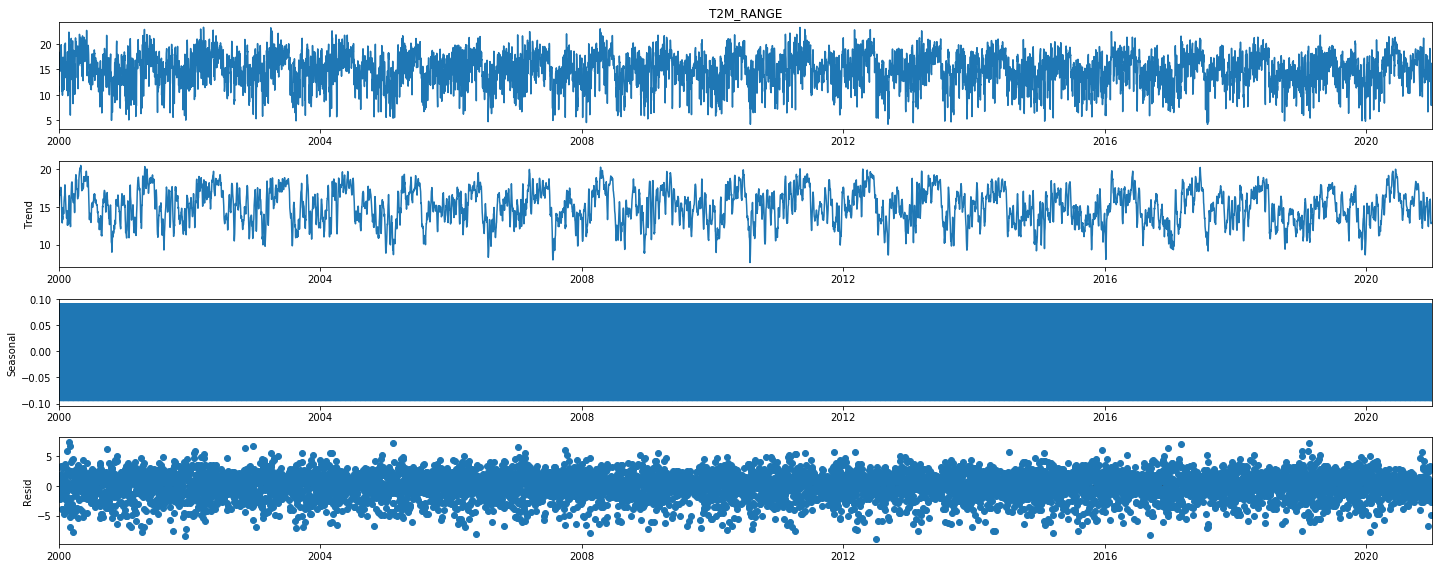

In [22]:
plt.rcParams['figure.figsize'] =20,8
fig=decomposition.plot()

## Conclusión de decomposición

Para la temperatura en Phenix Arizona, el componente mas importante es la tendencia de los datos, estando los valores de estacionalidad y residuales como muy variables y erráticos. 



# Prueba Augmented Dickey-Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfullera

In [24]:
# Your code here for Acceleration:
ADF_temp=adfuller(arizona['T2M_RANGE'])
Temp_pvalue=ADF_temp[1]

print('The P value of temperature in phoenix is', Temp_pvalue )

The P value of temperature in phoenix is 2.4564000865704992e-21


### Conclusión

pvalue tan pequeño es evidencia de un comportamiento no estacionario dado que hay constantes cambios de temperatura en la sdistintas temproadas del año (primavera, verano, otoño, invierno)

# Analisis PCA

La intención de las siguientes celdas es reducir el tamaño de las dimensiones de nuestro dataset original en compomentes principales.

In [25]:
from sklearn.preprocessing import StandardScaler


In [37]:
#el primer paso es normalizar con promedio cero nuestros datos

#Hacemos copia de nuestros datos

copy_maindf=main_df.copy()
copy_maindf=copy_maindf[copy_maindf.MONTH!=13]  #eliminamos el mes 13 que significaba el promedio anual
copy_maindf.drop(['CITY'], axis=1, inplace=True) # eliminamos columna categorica (aunque pudieramos haberlo convertido a Hot Encoding)


scaler=StandardScaler()
norm_data=scaler.fit_transform(copy_maindf)  #hacemos fit y transform a la vez , valore snormalizados a mean zero y std=1

norm_data

array([[-1.59325501, -1.55215667, -1.61083512, ..., -2.01243651,
        -1.11031085,  1.39760195],
       [ 1.01388955, -0.76117504, -0.77631827, ..., -0.34336342,
        -0.20539555,  0.65352395],
       [ 1.30357228, -1.44791878, -1.46125191, ..., -1.03268458,
        -0.6283451 ,  1.11765182],
       ...,
       [ 0.14484136,  0.91276282,  1.17613626, ...,  0.79425752,
         1.14214136,  0.21149742],
       [ 0.43452409,  0.39770502,  0.69983183, ...,  0.72918175,
         0.97492875,  0.115725  ],
       [ 0.72420682, -0.08669458, -0.01659302, ...,  0.23267769,
         0.28640624,  0.77876481]])

In [40]:
main_df.columns.drop('CITY')

Index(['MONTH',
       'All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day',
       'Top-of-atmosphere Insolation kW-hr/m^2/day', 'Daylight Cloud Amount %',
       'Direct Normal Radiation kW-hr/m^2/day',
       'Equivalent Number Of NO-SUN Or BLACK Days Over A Consecutive Month Period days',
       'Frequency Of Broken-cloud Skies 10 - 70 % At 18 GMT %',
       'Frequency Of Clear Skies < 10% At 18 GMT %',
       'Frequency Of Near-overcast Skies >= 70% At 18 GMT %',
       'Insolation Clearness Index dimensionless',
       'Midday Insolation Incident On A Horizontal Surface W m-2',
       'Precipitation mm day-1', 'Surface Pressure kPa',
       'Specific Humidity at 2 Meters g/kg', 'Daylight Hours hours',
       'Surface Albedo dimensionless', 'Temperature at 2 Meters C',
       'Total Column Precipitable Water cm', 'Wind Speed at 50 Meters m/s'],
      dtype='object')

In [44]:

#main_df=main_df[main_df.MONTH!=13].index  #eliminamos el mes 13 que significaba el promedio anual


norm_df=pd.DataFrame(norm_data, index=main_df[main_df.MONTH!=13].index, columns=main_df.columns.drop('CITY'))
norm_df

,MONTH,All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day,Top-of-atmosphere Insolation kW-hr/m^2/day,Daylight Cloud Amount %,Direct Normal Radiation kW-hr/m^2/day,Equivalent Number Of NO-SUN Or BLACK Days Over A Consecutive Month Period days,Frequency Of Broken-cloud Skies 10 - 70 % At 18 GMT %,Frequency Of Clear Skies < 10% At 18 GMT %,Frequency Of Near-overcast Skies >= 70% At 18 GMT %,Insolation Clearness Index dimensionless,Midday Insolation Incident On A Horizontal Surface W m-2,Precipitation mm day-1,Surface Pressure kPa,Specific Humidity at 2 Meters g/kg,Daylight Hours hours,Surface Albedo dimensionless,Temperature at 2 Meters C,Total Column Precipitable Water cm,Wind Speed at 50 Meters m/s
0,-1.593255,-1.552157,-1.610835,1.014381,-1.117512,-0.278119,0.712882,-1.157343,0.731683,-0.869377,-1.582717,0.274634,1.014525,-1.358113,-1.501450,-0.532823,-2.012437,-1.110311,1.397602
1,1.013890,-0.761175,-0.776318,-0.246996,-0.391402,-0.566473,-0.709231,0.463380,-0.057307,-0.439170,-0.881674,0.572950,1.014525,-0.260472,-0.597079,-1.594782,-0.343363,-0.205396,0.653524
2,1.303572,-1.447919,-1.461252,0.568180,-1.091345,0.341308,-0.093207,-0.387653,0.429087,-1.012780,-1.646484,0.484811,1.060464,-0.788385,-1.297237,-1.594782,-1.032685,-0.628345,1.117652
3,1.593255,-1.699316,-1.784037,0.688311,-1.281050,0.928695,0.555169,-0.650867,0.325981,-1.156182,-1.837654,0.525491,1.029838,-1.190853,-1.670655,-1.329293,-1.664161,-0.972606,1.323931
5,-1.303572,-1.006441,-1.024311,0.911411,-0.607272,0.282569,0.671095,-1.256336,0.851227,-0.439170,-0.945375,0.118696,0.994107,-1.352886,-0.871308,-0.798313,-1.935310,-1.120147,1.456539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-0.434524,0.483548,1.077726,0.962896,-0.299820,0.079653,-1.619114,-0.403768,1.289804,-0.725975,0.201841,0.688209,-0.103328,-0.127187,1.375032,-0.001844,-0.272262,0.070013,1.301830
152,-0.144841,0.863710,1.309974,0.525276,0.158087,-1.447554,-0.869640,-0.317821,0.791455,-0.439170,0.584246,0.627189,-0.113536,0.667296,1.742615,-0.001844,0.400188,0.758536,0.587220
153,0.144841,0.912763,1.176136,-0.178349,0.406665,0.875296,0.534949,-0.279452,-0.024433,-0.008963,0.647947,0.539050,-0.062493,1.171688,1.567576,0.263646,0.794258,1.142141,0.211497
154,0.434524,0.397705,0.699832,-0.289900,-0.038159,-0.966964,0.357017,-0.324728,0.117526,-0.295768,0.265542,0.688209,-0.011449,1.020109,0.966607,-0.001844,0.729182,0.974929,0.115725


Text(0.5, 1, 'Correlation matrix')

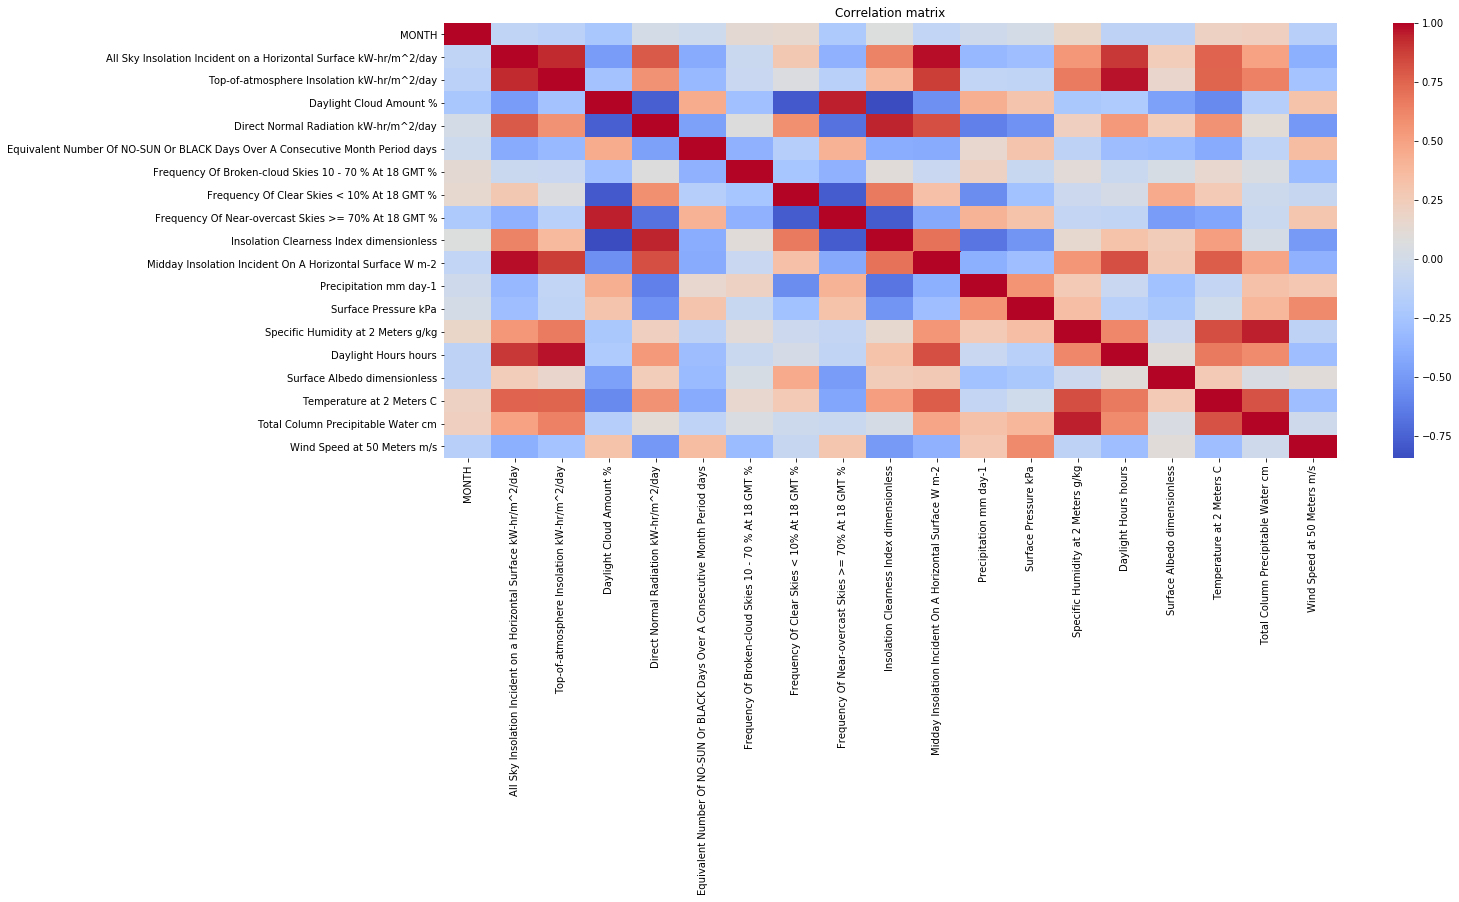

In [47]:
sns.heatmap(norm_df.corr(method='spearman') ,cmap='coolwarm')
plt.title('Correlation matrix')

#### Procedemos a utilizar PCA 

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA()
pca.fit(norm_df)  

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
pca.explained_variance_ratio_   # es un array con la proporcion de cada columna numérica de mi main_df

array([4.22817224e-01, 2.09176488e-01, 1.05968326e-01, 7.71121407e-02,
       6.50743778e-02, 3.45594439e-02, 2.68651994e-02, 1.95613176e-02,
       1.60425916e-02, 1.20545869e-02, 5.34345738e-03, 1.54437589e-03,
       1.38691996e-03, 1.09498643e-03, 7.85981351e-04, 4.16436461e-04,
       1.36334544e-04, 5.98097422e-05, 3.03592154e-09])

In [52]:
sum(pca.explained_variance_ratio_)  # la suma de todas las proporciones es igual a uno

1.0000000000000002

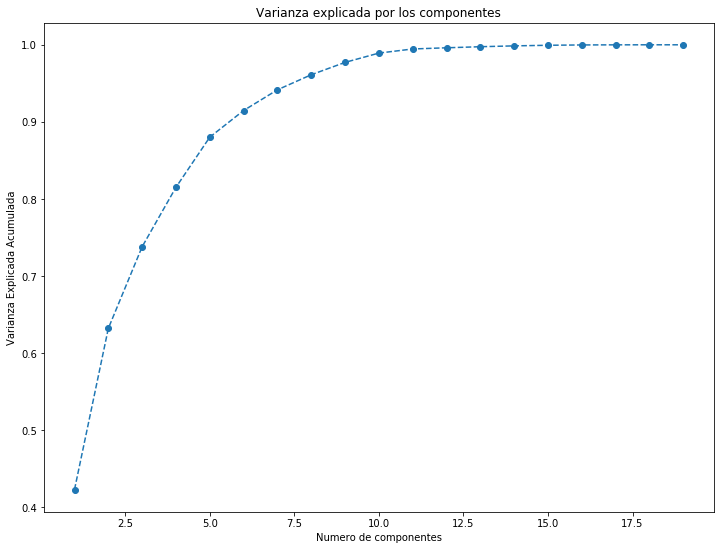

In [60]:
plt.figure(figsize=(12,9))
plt.plot(range(1,20), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--") # en range debe de coincidir en la dimension el range, con el numero de componente de la matriz
plt.title("Varianza explicada por los componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada Acumulada"); #Regla de oro es quedarnos con el 80% de la varianza

##### De observar la gráfica anterior, podemos concluir que utilizando los 4 primeros componentes del PCA tenemos mas del 80% de la varianza de los datos

Por ello utilizamos, volveremos a utilizar el método PCA, pero ahora ajustando con las 4 dimensiones que representan el 80% del valor de la varianza

In [61]:
pca = PCA(n_components= 4)
pca.fit(norm_df)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [62]:
# para ver el nuevo array

pca.components_

array([[ 0.0184069 ,  0.31797302,  0.2625954 , -0.29123254,  0.32705134,
        -0.17531941,  0.03663487,  0.24217673, -0.25608479,  0.30763723,
         0.32397467, -0.20428841, -0.16856567,  0.13827935,  0.238243  ,
         0.1279942 ,  0.27862201,  0.12642021, -0.16089414],
       [ 0.00216845,  0.1408095 ,  0.27483357,  0.16356959, -0.12634789,
         0.01089655,  0.0918573 , -0.27687602,  0.21863837, -0.19236735,
         0.12048975,  0.28290033,  0.29846896,  0.42390698,  0.27428722,
        -0.1467359 ,  0.2359035 ,  0.41948657,  0.01324214],
       [-0.37484206,  0.2110335 ,  0.23711683,  0.25091332,  0.11871266,
         0.21264859, -0.50408847, -0.0368676 ,  0.31533233,  0.02541127,
         0.19370043, -0.21687763, -0.01363739, -0.17911487,  0.25535322,
        -0.1640961 , -0.14218078, -0.22300492,  0.04490455],
       [-0.01977504,  0.02243425,  0.00304653,  0.14261132,  0.04473847,
        -0.26090402,  0.34989614, -0.31704637,  0.11469297,  0.03369709,
        -0.016

#### Si nos damos cuenta, ahora los 19 parámetros están incluidos en cada uno de los 4 componentes del PCA

In [64]:
df_pca_comp = pd.DataFrame(data=pca.components_,
                           columns = main_df.columns.drop('CITY'),
                           index = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3',  'Componente Principal 4']
                           )

#hicimos match nuevamente entre el array de pca.components, con los nombres de las columnas (donde dropeamos CIty)
# y con los nuevos indices donde nosotros les dimos su string respectiva

df_pca_comp

,MONTH,All Sky Insolation Incident on a Horizontal Surface kW-hr/m^2/day,Top-of-atmosphere Insolation kW-hr/m^2/day,Daylight Cloud Amount %,Direct Normal Radiation kW-hr/m^2/day,Equivalent Number Of NO-SUN Or BLACK Days Over A Consecutive Month Period days,Frequency Of Broken-cloud Skies 10 - 70 % At 18 GMT %,Frequency Of Clear Skies < 10% At 18 GMT %,Frequency Of Near-overcast Skies >= 70% At 18 GMT %,Insolation Clearness Index dimensionless,Midday Insolation Incident On A Horizontal Surface W m-2,Precipitation mm day-1,Surface Pressure kPa,Specific Humidity at 2 Meters g/kg,Daylight Hours hours,Surface Albedo dimensionless,Temperature at 2 Meters C,Total Column Precipitable Water cm,Wind Speed at 50 Meters m/s
Componente Principal 1,0.018407,0.317973,0.262595,-0.291233,0.327051,-0.175319,0.036635,0.242177,-0.256085,0.307637,0.323975,-0.204288,-0.168566,0.138279,0.238243,0.127994,0.278622,0.126420,-0.160894
Componente Principal 2,0.002168,0.140810,0.274834,0.163570,-0.126348,0.010897,0.091857,-0.276876,0.218638,-0.192367,0.120490,0.282900,0.298469,0.423907,0.274287,-0.146736,0.235903,0.419487,0.013242
Componente Principal 3,-0.374842,0.211034,0.237117,0.250913,0.118713,0.212649,-0.504088,-0.036868,0.315332,0.025411,0.193700,-0.216878,-0.013637,-0.179115,0.255353,-0.164096,-0.142181,-0.223005,0.044905
Componente Principal 4,-0.019775,0.022434,0.003047,0.142611,0.044738,-0.260904,0.349896,-0.317046,0.114693,0.033697,-0.016105,-0.005178,-0.307053,-0.101260,0.092727,-0.378175,-0.105600,-0.160188,-0.614982


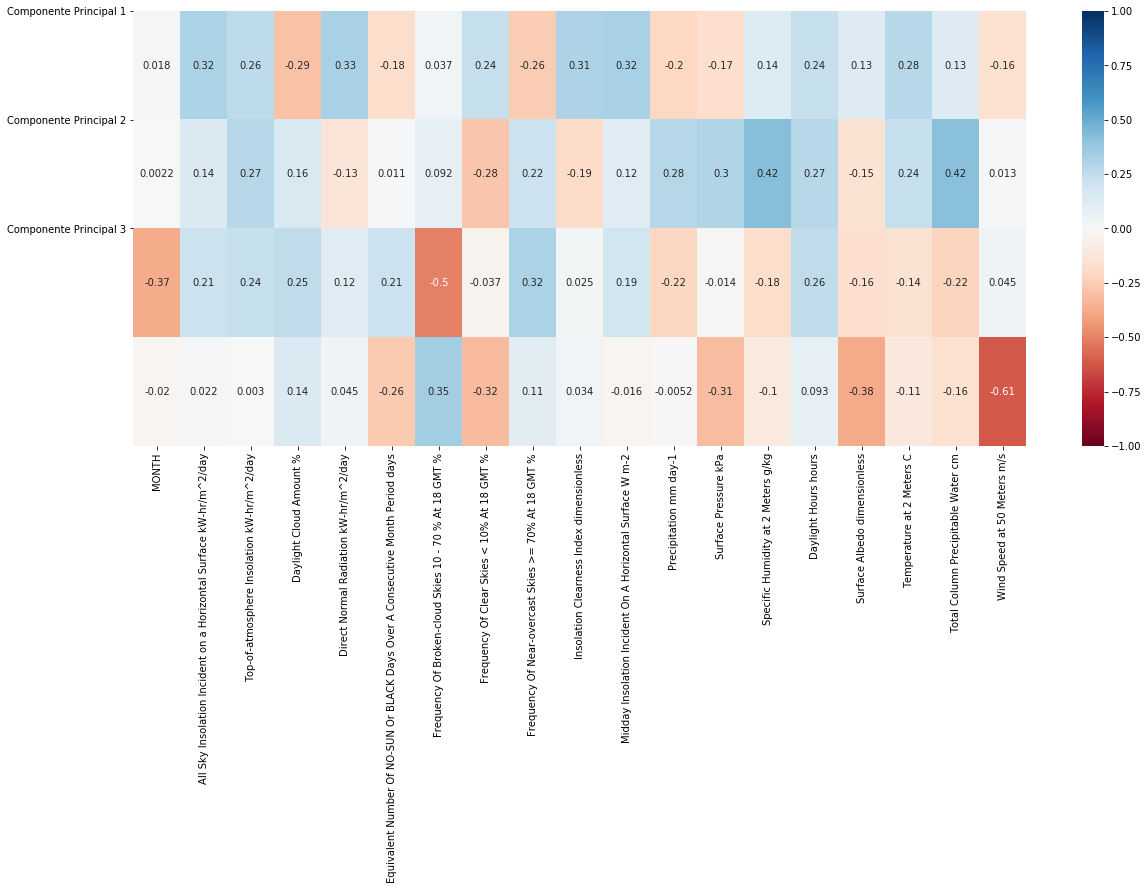

In [65]:
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap='RdBu',
            annot=True
            )
plt.yticks([0,1,2],
           ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3', 'Componente Principal 4']
           );

In [66]:
df_transform = pca.transform(copy_maindf)
df_transform

array([[ 50.27801462,  96.97996836,  84.63120927, -18.2854147 ],
       [102.95438161, 104.84033906,  97.45601919, -34.89746137],
       [ 54.7472101 ,  94.17335084,  77.80828999, -26.00814706],
       [ 42.13221307,  89.56599198,  70.30010558, -22.51402692],
       [ 82.39096339, 109.9045599 , 104.44289373, -19.75893519],
       [115.79392571, 123.05243569, 127.97696279, -24.71317256],
       [138.36298825, 127.29146304, 137.19609008, -31.78531569],
       [156.97319766, 136.57019242, 144.8772008 , -33.37163029],
       [170.11039476, 143.55390947, 145.03076587, -32.33292875],
       [172.74058914, 144.99367888, 140.28985934, -30.91596059],
       [159.81792239, 138.93702992, 132.15176068, -31.09051379],
       [134.60878098, 124.27579351, 114.55360301, -31.70394756],
       [106.09919145, 103.40348335,  89.37216977, -22.62229977],
       [165.43111397, 113.47524557, 108.77394138, -34.40509136],
       [131.75504977,  98.73025231,  89.04176802, -33.542263  ],
       [100.3709915 ,  97

In [71]:
data_pca = pd.DataFrame(df_transform, columns=['C!', 'C2', 'C3', 'C4'])
data_pca

,C!,C2,C3,C4
0,50.278015,96.979968,84.631209,-18.285415
1,102.954382,104.840339,97.456019,-34.897461
2,54.747210,94.173351,77.808290,-26.008147
3,42.132213,89.565992,70.300106,-22.514027
4,82.390963,109.904560,104.442894,-19.758935
...,...,...,...,...
139,147.262902,135.720116,146.600529,-32.127623
140,173.178091,143.756312,149.597480,-32.535134
141,182.562856,143.577061,140.253201,-33.111993
142,162.785411,135.817456,128.252246,-31.496217


Text(0.5, 1, 'Correlation matrix')

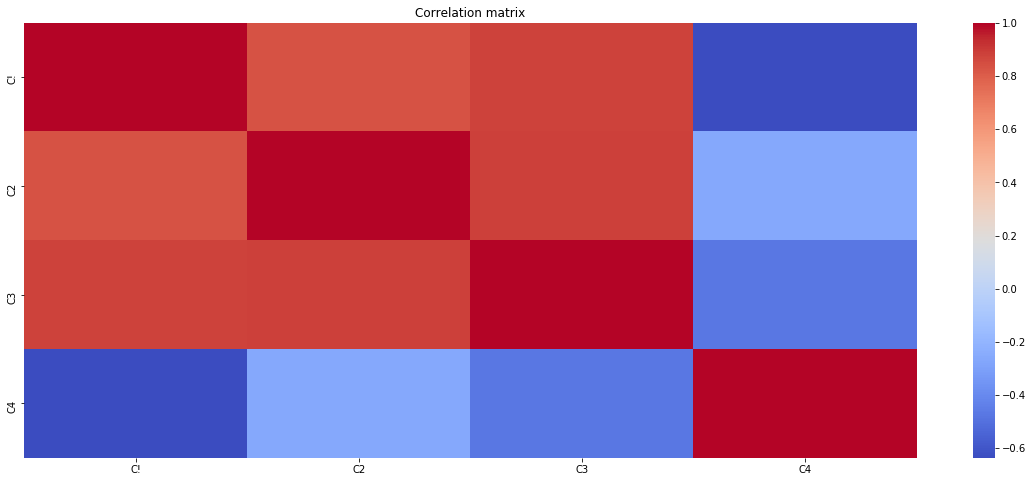

In [72]:
sns.heatmap(data_pca.corr(method='spearman') ,cmap='coolwarm')
plt.title('Correlation matrix')

### Y con esto, creamos una nueva matriz de correlaciones

Donde se compara el nivel de correlación entre cada uno de los 4 componentes creados a partir del método PCA, 

Recordemos que cada componente tiene dentro de si mismo, un compendio de los valores de cada uno de los parámetros en nuestro dataframe original, solo que ahora los redujimos a 4  componentes, con el objetivo de en el futuro, facilitar el análisis de la data con componentes reducidos .

### Como comparación

Abajo insertamos la matriz de correlación con los 19 parámetros de estudio. Procesar modelos avanzados con tantas variables seria un trabajo muy intensivo, es por ello que utilizamos la técnica PCA para reducir la dimensionalidad de nuestros datos

Text(0.5, 1, 'Correlation matrix')

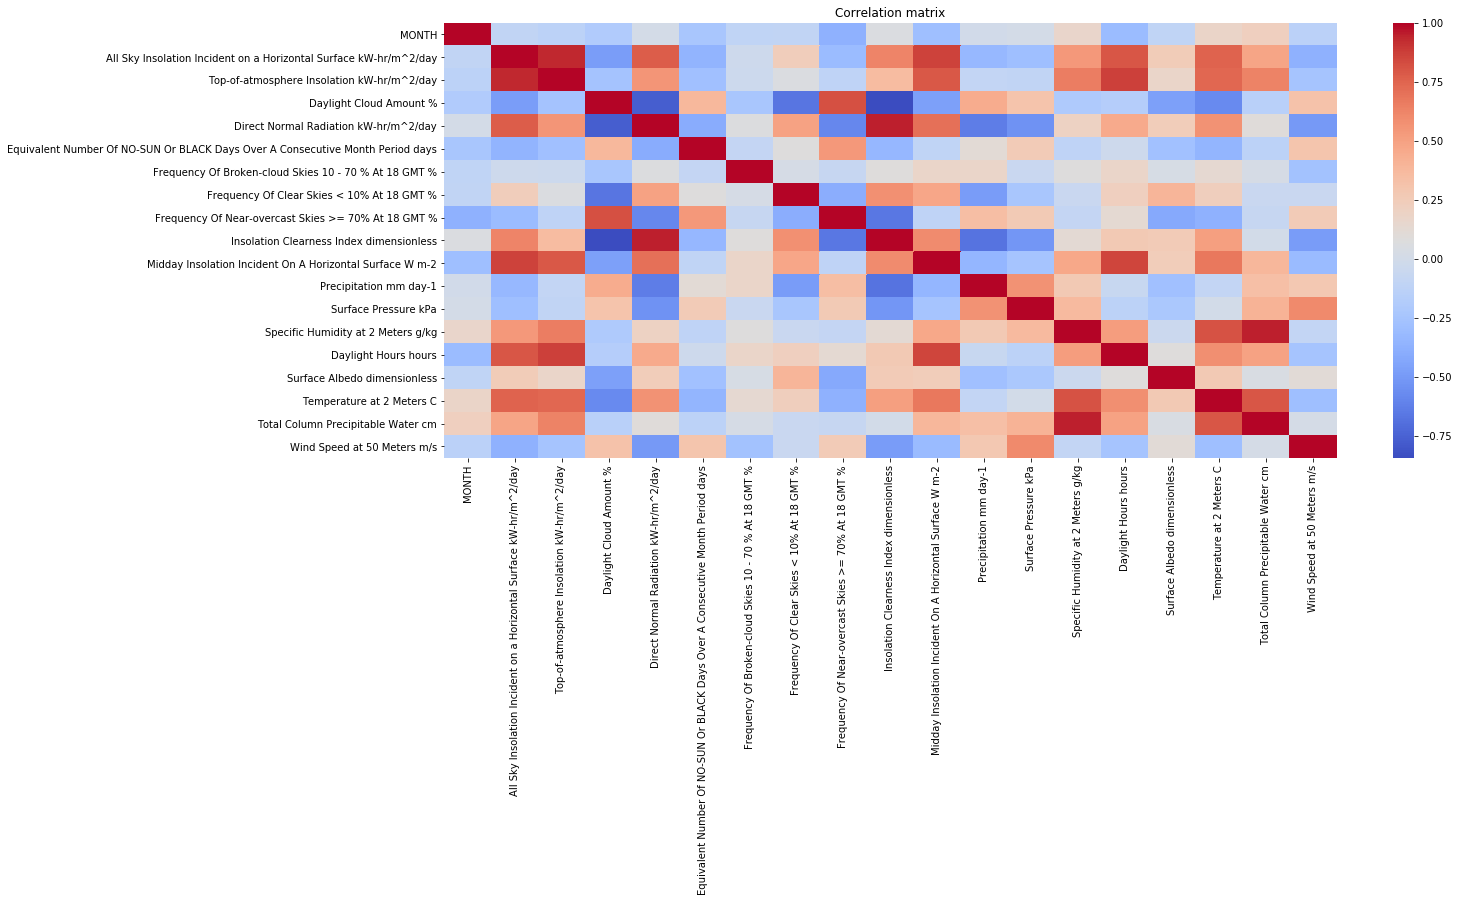

In [75]:
sns.heatmap(main_df.drop(['CITY'], axis=1).corr(method='spearman') ,cmap='coolwarm')
plt.title('Correlation matrix')
